In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

np.random.seed(1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Gaps across the years

In a previous kernel I estimated the SHSAT applicants gap that happened in 2017. It measures the amount of applicants that took the SHSAT less than what we expected. In this kernel, I will try to understand how this gap evolves across the years and, try to answer one question:

"Is the estimated gap for 2017 still relevant when we talk about 2018?"

In the way to find the answer, I will take the following steps:

- Calculate the gap of applicants that happened from 2013 to 2016 in Central Harlem (a district of NYC)
- Compare the gaps that happened in each year to the gaps of the subsequent years
- Visualize the results
- Infer what this relation mean to our most recent data


# Data used

The data used in this kernel is quite different from the last one. Basically, we are targeting schools from Central Harlem, this region in New York:

![](../data/keep/map-harlem.png)

Characteristics from the data:

- Made as a mix between the handed-out D5 dataset and a dataset available in the [NYC InfoHub][1]
- Comprehends 24 schools from Central Harlem (18 after dropping those with missing values)
- From 2013 to 2016
- NYS test results for 7th graders
- SHSAT statistics for 8th graders

In [2]:
# prepare dataframe
df = pd.read_pickle('../data/process/d5_shsat.pkl')
df = df.reset_index()
print(df['DBN'].nunique(), "schools")

# drop entries with missing test results
df = df[df.notnull().any(axis=1)]
print(df['DBN'].nunique(), "schools after dropping missing Common Core entries")

# drop schools that were not present in all years of this dataset
counts_per_school = df.groupby('DBN').size()
df = df[df['DBN'].apply(lambda x: counts_per_school[x] == 4)]
print(df['DBN'].nunique(), "schools after dropping schools with missing years information")

# reset index
df = df.set_index(['DBN', 'Year'])

df.head()

24 schools
24 schools after dropping missing Common Core entries
18 schools after dropping schools with missing years information


Charter School?  Number Tested - ELA  Mean Scale Score - ELA  \
DBN    Year                                                                 
05M046 2013              0.0                 84.0               -1.117422   
       2014              0.0                 85.0               -1.628713   
       2015              0.0                 66.0               -1.380656   
       2016              0.0                 58.0               -1.103425   
05M123 2013              0.0                 55.0               -1.045237   

             # Level 1 - ELA  % Level 1 - ELA  # Level 2 - ELA  \
DBN    Year                                                      
05M046 2013             47.0         55.95238             29.0   
       2014             57.0         67.05882             22.0   
       2015             41.0         62.12121             16.0   
       2016             39.0         67.24138             14.0   
05M123 2013             30.0         54.54545             20.0   

             % Level 2 - ELA  # Level 3 - ELA  % Level 3 - ELA  \
DBN    Year                                                      
05M046 2013         0.345238              7.0         0.083333   
       2014         0.258823              6.0         0.070588   
       2015         0.242424              9.0         0.136364   
       2016         0.241379              2.0         0.034483   
05M123 2013         0.363636              5.0         0.090909   

             # Level 4 - ELA  % Level 4 - ELA  # Level 3+4 - ELA  \
DBN    Year                                                        
05M046 2013              1.0         0.011905                8.0   
       2014              0.0         0.000000                6.0   
       2015              0.0         0.000000                9.0   
       2016              3.0         0.051724                5.0   
05M123 2013              0.0         0.000000                5.0   

             % Level 3+4 - ELA  Number Tested - Math  Mean Scale Score - Math  \
DBN    Year                                                                     
05M046 2013           9.523810                  88.0                -0.744606   
       2014           7.058824                  87.0                -1.012577   
       2015          13.636360                  67.0                -0.977286   
       2016           8.620690                  58.0                -1.679011   
05M123 2013           9.090909                  61.0                -1.690491   

             # Level 1 - Math  % Level 1 - Math  # Level 2 - Math  \
DBN    Year                                                         
05M046 2013              50.0          56.81818              31.0   
       2014              56.0          64.36782              26.0   
       2015              39.0          58.20896              23.0   
       2016              48.0          82.75862              10.0   
05M123 2013              47.0          77.04918              11.0   

             % Level 2 - Math  # Level 3 - Math  % Level 3 - Math  \
DBN    Year                                                         
05M046 2013          0.352273               7.0          0.079545   
       2014          0.298851               5.0          0.057471   
       2015          0.343284               4.0          0.059701   
       2016          0.172414               0.0          0.000000   
05M123 2013          0.180328               3.0          0.049180   

             # Level 4 - Math  % Level 4 - Math  # Level 3+4 - Math  \
DBN    Year                                                           
05M046 2013               0.0          0.000000                 7.0   
       2014               0.0          0.000000                 5.0   
       2015               1.0          0.014925                 5.0   
       2016               0.0          0.000000                 0.0   
05M123 2013               0.0          0.000000                 3.0   

             % Level 3+4 - Math  Enr

# Calculate the gap of applicants

## Cross-validation

We will use a repeated k-fold CV, like in the last kernel<sup>1</sup>.

<sub>1: But with different params: n_splits=6, n_repeats=50</sub>

In [3]:
inputs = df[[
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]

outputs = logit(df['% SHSAT Testers'])

In [4]:
# cross-validation
cv_results = []
n_splits = 5
n_repeats = 50
for n_components in range(1, inputs.shape[1] + 1):
    mae_scores = []
    mse_scores = []
    
    x = PCA(n_components).fit_transform(inputs)
    x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
    x['Constant'] = 1
    y = outputs.copy()
    

    cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
    for train, test in cv.split(x):
        x_train = x.iloc[train]
        x_test = x.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        model = sm.RLM(y_train, x_train, M=sm.robust.norms.HuberT())
        results = model.fit()
        predictions = model.predict(results.params, exog=x_test)
        mae = median_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mae_scores.append(mae)
        mse_scores.append(mse)
        
    mae_scores = np.array(mae_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
    mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        
    mae_mean = np.mean(mae_scores)
    mae_std = np.std(mae_scores)
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    
    cv_result = (n_components, mae_mean, mse_mean, mae_std, mse_std)
    cv_results.append(cv_result)
    
df_columns = ['n_components', 'mae__mean', 'mse__mean', 'mae__std', 'mse__std']
cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
cv_results_df

,n_components,mae__mean,mse__mean,mae__std,mse__std
0,1,0.372806,0.338054,0.024079,0.010404
1,2,0.377464,0.348891,0.024503,0.011443
2,3,0.382596,0.337738,0.024715,0.012174
3,4,0.386913,0.360318,0.028032,0.019821
4,5,0.400876,0.382955,0.029590,0.027587
5,6,0.413856,0.386823,0.025827,0.026424
6,7,0.425565,0.396861,0.028203,0.028009
7,8,0.430833,0.406324,0.031850,0.029856


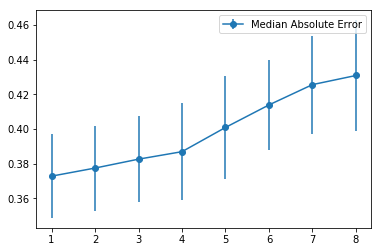

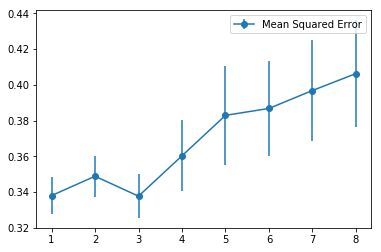

In [5]:
# visualize results

cvdf = cv_results_df  # code sugar

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mae__mean, cvdf.mae__std, marker='o', label='Median Absolute Error')
plt.legend()

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mse__mean, cvdf.mse__std, marker='o', label='Mean Squared Error')
plt.legend();

One pricipal component is the number that works best (:

## Model

As there are so few schools (and because I'm running with things), we are gonna use less explanatory variables. Only the NYS test results and we hope this will suffice to produce a good model from which we can generalize.

First we transform the inputs, then we fit them to the target logit values.

In [6]:
inputs = df[[
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]
inputs = pd.DataFrame(PCA(1).fit_transform(inputs), index=inputs.index, columns=['PC1'])
inputs['Constant'] = 1

outputs = logit(df['% SHSAT Testers'])

In [7]:
# model

# fit the model
model = sm.RLM(outputs, inputs, M=sm.robust.norms.HuberT())
results = model.fit()
predictions = model.predict(results.params, exog=inputs)
predictions = pd.Series(predictions, index=inputs.index, name='% SHSAT Testers')
residuals = outputs - predictions
pct_residuals = expit(outputs) - expit(predictions)

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                   72
Model:                            RLM   Df Residuals:                       70
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Aug 2018                                         
Time:                        23:27:07                                         
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            0.2310      0.047      4.885      0.000       0.138       0.324
Constant      -1.5500      0.065    -23.995      0.000      -1.677      -1.423
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

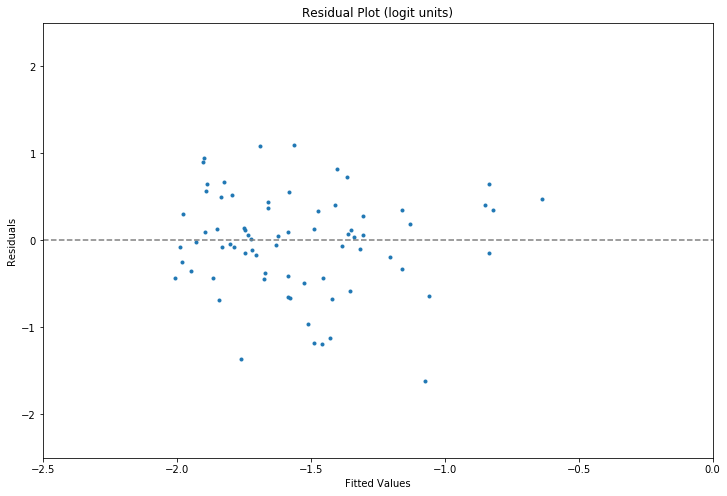

In [9]:
_predictions = predictions
_actual = outputs

xs = _predictions
ys = _actual - _predictions  # residual

plt.figure(figsize=(12, 8))
plt.plot(xs, ys, '.')
plt.axhline(0.0, linestyle='--', color='gray')
plt.xlim(-2.5, 0)
plt.ylim(-2.5, 2.5)
plt.title("Residual Plot (logit units)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals");

In [10]:
mae = median_absolute_error(_actual, _predictions)
mse = mean_squared_error(_actual, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.373875592728352
Mean Squared Error: 0.32039256405417776


Comparing with the original model:

- MedAE: 0.34 (+0.03)
- MSE: 0.43 (-0.11)

This probably means we've got less ouliers, but a tid bit worse fit.

# Compare gaps across the years

Well... We need a way to compare gaps from one year to the other. To do so, I will assume the gap in each school follows a certain formula:

$G_y = w \cdot G_{y-1} + (1 - w) \cdot B + \epsilon$

Where:

- $G_y$ is the gap in the year y
- $B$ is the baseline gap of the school
- $w$ is a weight used to balance the  past year gap and the baseline gap
- $\epsilon$ is an error term and denotes noise from students of one year to the other

Ideally, we would want to know B. B can indicate a range of factors, like a school not having enough incentive for SHSAT, a trend of underconfidence among students, a good exposure of SHSAT in a school, etc.

We can't, however, know the exact value of B. So we use an estimate for it. And I'd argue that the best estimate we have for it is the actual gap that happened in 2017 (that is, when we consider the big dataset). So we simplify the formula above to:

$G_y = G_{y-1} + \epsilon$

And this is what we are gonna base ourselves upon.

Now I will make some visualizations comparing the estimated gaps for each school along the years. Below the graphs there is an explanation.

/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


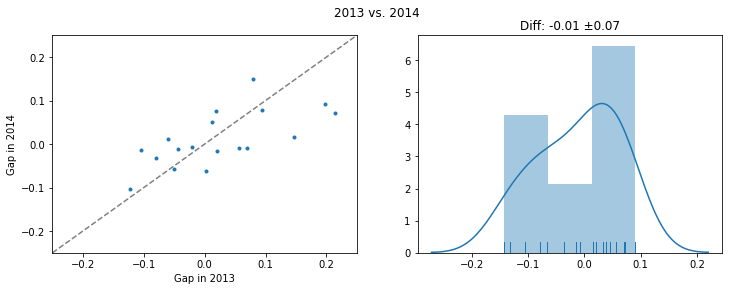

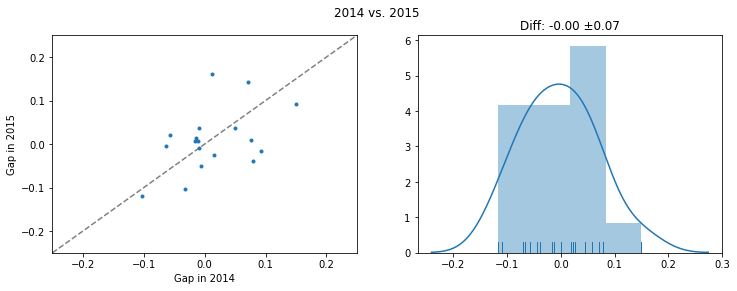

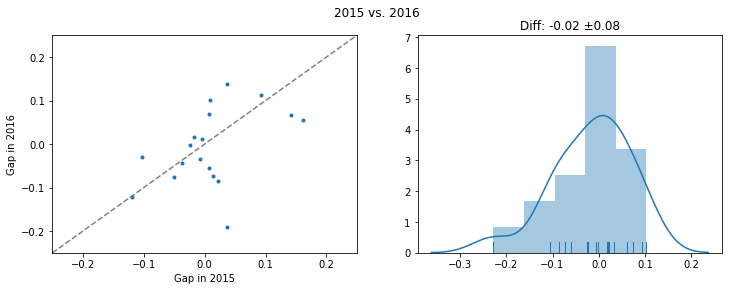

In [11]:
pivoted = pct_residuals.reset_index().pivot(index='DBN', columns='Year', values='% SHSAT Testers')

combinations = [
    (2013, 2014),
    (2014, 2015),
    (2015, 2016),
]

for y1, y2 in combinations:
    diffs = (pivoted[y2] - pivoted[y1])
    mean = diffs.mean()
    std = diffs.std()
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    fig.suptitle("%s vs. %s" % (y1, y2))

    ax1.plot([-0.25, 0.25], [-0.25, 0.25], '--', color='gray')
    ax1.plot(pivoted[y1], pivoted[y2], '.')
    ax1.set_xlabel("Gap in %s" % y1)
    ax1.set_ylabel("Gap in %s" % y2)
    ax1.set_xlim(-0.25, 0.25)
    ax1.set_ylim(-0.25, 0.25)

    sns.distplot(diffs, ax=ax2, rug=True)
    ax2.set_title("Diff: {:.2f} ±{:.2f}".format(mean, std))

**Left**:

The left plots compare the percentual gaps of each school in one year to the percentual gaps in the next year. If one year was totally indicative of the other, the points would be right on top of the dashed line.

As you can see, the points do not fit completely the line. However they do follow it and this is an indication that the gaps of one year follow the gaps of the previous one.

**Right**:

The right plots represent the distribution of errors. The plot titles gives the mean plus standard deviation of the distribution. This is a good way of  

As you can see,

While the left plots compares one variable to the other, the right plots present the distribution of errors.

As you can see, the distribution of errors follows almost a normal distribution, centered at zero and with standard deviation around 0.07. This is a good indicator, as we can say that, if the gap in a school is 22% one year, the next year this gap will be sopmething around 22% +- 8%.

And this means that the gap in one year is indeed somewhat close to the gap in the past year. And the expected gap for the next year is just the gap of the current year. Of course, if we had more data from other years, we could better be able to create a time series model, but, as only data from 2017 is available for all schools, this simple model will suffice.

One thing I would like to note is that school way under the diagonal line in the lower-left corner. This corresponds to a given school:

In [12]:
# show school here

We can see that there was some weird shift between the number of applicants in 2015 and 2016 and the model not predicting the gap is exactly what we would expect.

# Limitations of this approach

We used limited data and in a way that is different from the actual 2017 model. Given that this comprehend a much smaller geographic region than the whole city of New York, we can expect that the variance of the error when comprehending all schools may be higher than what was found here.

And, what does this error mean? In this model it is just the amount of the gap in one year that cannot be predicted by the previous. We can say, some noise in the student populations, combined of what would be expected of each school.

# Does this effect the relevance of the "Predicting the applicants gap" kernel

Well, in a certain way, it adds more uncertainty in the model. Or more acuratelly, it measures uncertainty that was already present there. The important thing to note though, is that, while we have an uncertainty in predicting the gap for next year, this uncertainty is inherent to the system, and having a model that can work, despite this uncertainty, is better than having none.

I personally believe the gap can be better estimated as a composite of a given baseline for each school and what happened in the previous years. This baseline would measure certain aspects that cannot be captured in our models, like, how much informed the school is about SHSAT, the confidence of students in it, etc... But, it can't be measured directly and the best estimate we have of it is actually the gap we estimated in 2017.

**example of what school would you choose**

So, that's it.